# In this notebook, LSTM Univariate models will be explored

In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

## LSTM

#### Reload the data

The plan:

First run only price data to do a univariate LSTM ... DONE
Check results for all data including 2020 ... Poor Results

Check results for 2019 data only ... DONE, good results
Compare predictions with known 2020 data ... DONE dood results

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

In [2]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return timestamp

In [3]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [4]:
# # chop out 2020 data
# df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [5]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Kgs')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

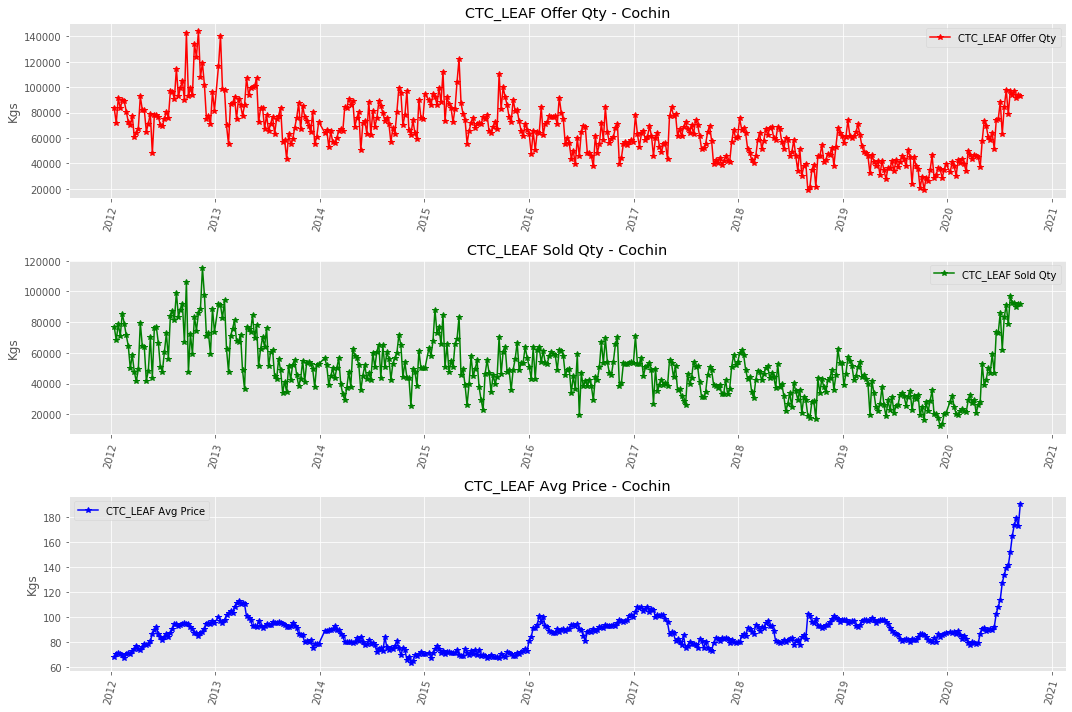

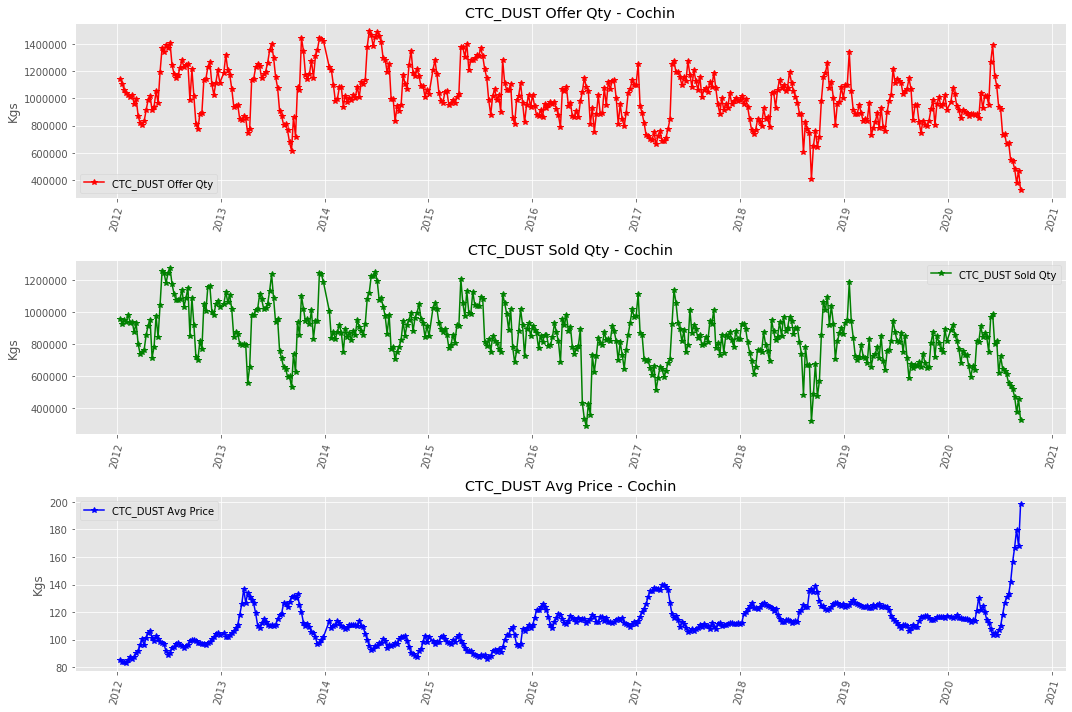

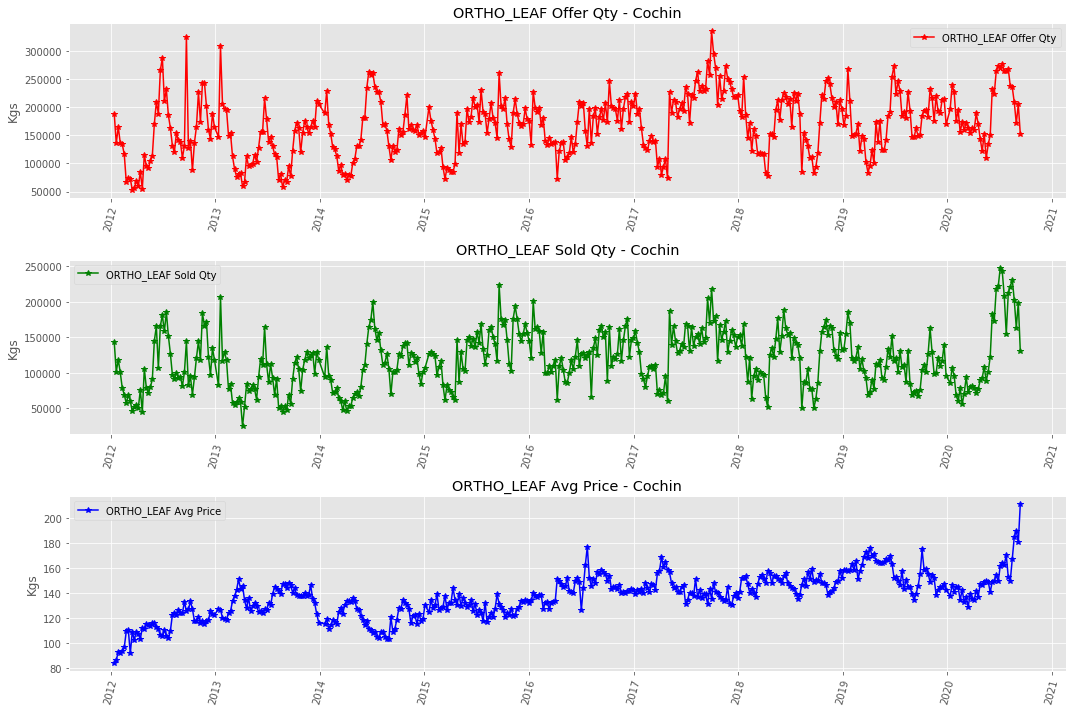

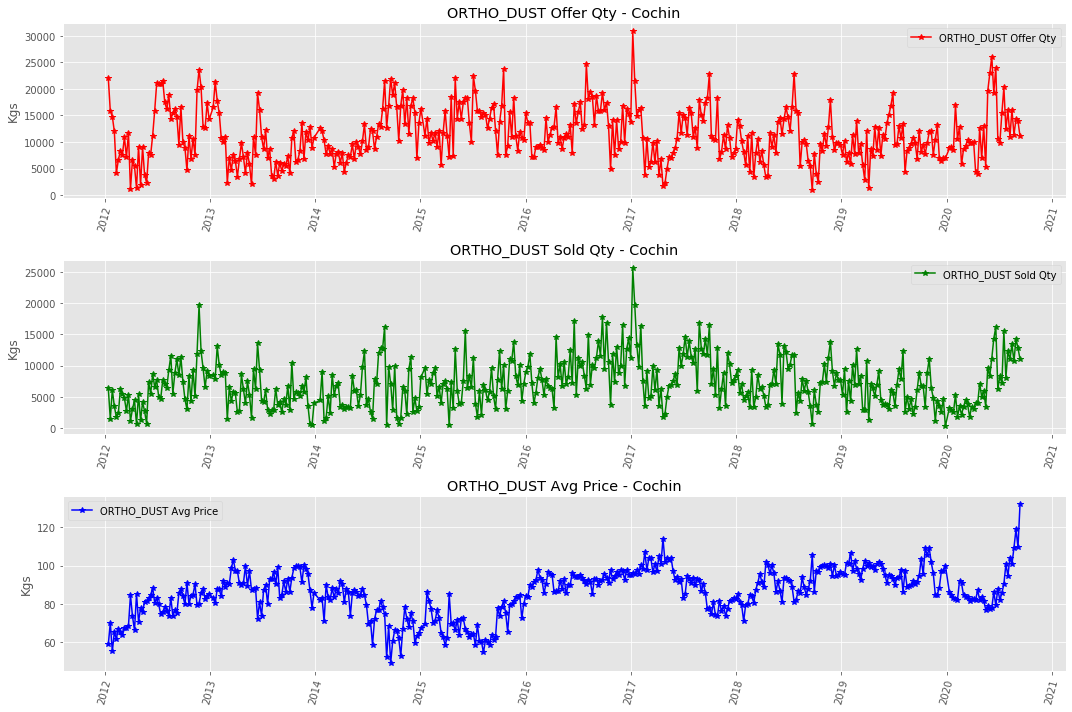

In [6]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

## Univariate

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 52 values followed by one value (for the output) along our time-series data.

In [7]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '11-Jul-20', '18-Jul-20', '25-Jul-20', '1-Aug-20', '8-Aug-20',
       '15-Aug-20', '22-Aug-20', '29-Aug-20', '5-Sep-20', '12-Sep-20'],
      dtype='object', name='week_ending', length=448)

In [8]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [9]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [10]:
df_CHN_CTC_leaf

,year,serial_no,ctc_leaf_offer_qty,ctc_leaf_sold_qty,ctc_leaf_avg_price
week_ending,,,,,
14-Jan-12,2012,2,83325.00,77015.00,68.03
21-Jan-12,2012,3,71897.00,68187.00,70.11
28-Jan-12,2012,4,91279.00,78695.00,70.73
4-Feb-12,2012,5,83746.00,71188.00,70.63
11-Feb-12,2012,6,89650.00,85480.00,69.23
...,...,...,...,...,...
15-Aug-20,2020,33,93637.00,92640.00,165.10
22-Aug-20,2020,34,96829.00,92338.00,174.03
29-Aug-20,2020,35,91799.00,89785.00,179.36


In [11]:
n_prev = 6

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

((409, 6, 1), (27, 6, 1), (409,), (27,))

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [12]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [13]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.Dropout(0.1))

LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mse')

In [14]:
LSTM_price_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 52)             11232     
_________________________________________________________________
dropout (Dropout)            (None, 6, 52)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 52)                21840     
_________________________________________________________________
dense (Dense)                (None, 1)                 53        
Total params: 33,125
Trainable params: 33,125
Non-trainable params: 0
_________________________________________________________________


In [18]:
LSTM_price_model_history = LSTM_price_model.fit(x_train, y_train, batch_size=10, epochs=5000)


Epoch 1/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 2/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 3/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 4/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 5/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5195
Epoch 6/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 7/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5195
Epoch 8/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 9/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 10/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 11/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 12/5000
41/41 [==============================] - 0s 4ms/step - loss:

41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 98/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 99/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 100/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 101/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 102/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 103/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 104/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 105/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 106/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 107/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 108/5000
41/41 [==============================] - 0s 4ms/step - l

41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 193/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 194/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 195/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 196/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 197/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 198/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 199/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 200/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 201/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 202/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 203/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 288/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 289/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 290/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 291/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 292/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 293/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 294/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 295/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 296/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 297/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 298/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 383/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 384/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 385/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 386/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 387/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 388/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 389/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 390/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 391/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 392/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 393/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 478/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 479/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 480/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 481/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 482/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 483/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 484/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 485/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 486/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 487/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 488/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 573/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 574/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 575/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 576/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 577/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 578/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5195
Epoch 579/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 580/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 581/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 582/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 583/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 668/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5161
Epoch 669/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 670/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 671/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 672/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 673/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 674/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 675/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 676/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 677/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 678/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 763/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 764/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 765/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 766/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 767/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 768/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 769/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 770/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 771/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 772/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 773/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 858/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 859/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 860/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 861/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 862/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 863/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 864/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5195
Epoch 865/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 866/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 867/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 868/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 953/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 954/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 955/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 956/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 957/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 958/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 959/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 960/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 961/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 962/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 963/5000
41/41 [==============================] - 0s 4ms/step -

41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1047/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1048/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1049/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1050/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 1051/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1052/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 1053/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1054/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 1055/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 1056/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1057/5000
41/41 [==============================] - 0s

41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1141/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 1142/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1143/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1144/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1145/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1146/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1147/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1148/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1149/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5166
Epoch 1150/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1151/5000
41/41 [==============================] - 0s

41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1235/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1236/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1237/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1238/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1239/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1240/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1241/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1242/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1243/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1244/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1245/5000
41/41 [==============================] - 0s

41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1329/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5190
Epoch 1330/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1331/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1332/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5171
Epoch 1333/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5161
Epoch 1334/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5186
Epoch 1335/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1336/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1337/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1338/5000
41/41 [==============================] - 0s 4ms/step - loss: 7508.5176
Epoch 1339/5000
41/41 [==============================] - 0s

KeyboardInterrupt: 

In [18]:
# ## Pickle the model
# # Save the Modle to file in the current working directory
# timestamp =   str(datetime.now().year) + '_'\
#             + str(datetime.now().month).zfill(2) + '_'\
#             + str(datetime.now().day).zfill(2) + '_'\
#             + str(datetime.now().hour).zfill(2) + '_'\
#             + str(datetime.now().minute).zfill(2) + '_'\
#             + str(datetime.now().second).zfill(2)


# pickled_model_filename = '../Models/LSTM_price_model_' + LSTM_price_model.name + '_' + timestamp + '.pkl'  

# with open(pickled_model_filename, 'wb') as file:  
#     pickle.dump(LSTM_price_model, file)

# # Load the Model back from file
# with open(pickled_model_filename, 'rb') as file:  
#     pickled_LSTM_price_model = pickle.load(file)

# pickled_LSTM_price_model

## Predictions from LSTM Univariate

In [19]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[ 86.566925],
       [ 83.68038 ],
       [ 81.96615 ],
       [ 83.091125],
       [ 82.91676 ],
       [ 82.50559 ],
       [ 82.80858 ],
       [ 89.772064],
       [ 94.21246 ],
       [ 94.99487 ],
       [ 92.54536 ],
       [ 93.63965 ],
       [ 94.59136 ],
       [ 93.68958 ],
       [ 95.68529 ],
       [103.77274 ],
       [107.4289  ],
       [107.74539 ],
       [107.84083 ],
       [107.87297 ],
       [107.88202 ],
       [107.884964],
       [107.88692 ],
       [107.88896 ],
       [107.88986 ],
       [107.89053 ],
       [107.89075 ]], dtype=float32)

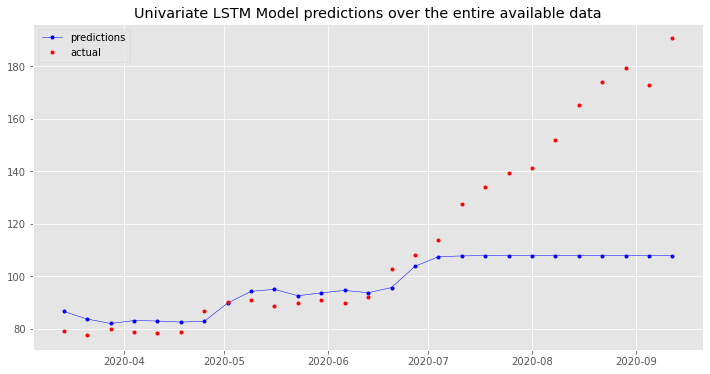

In [20]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the entire available data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata_entire_available' + get_timestamp())
ax.legend();

In [21]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [22]:
# Calaculate MAPE
print(f'MAPE for known data (before 2020) = {mape(price_series, y_pred)}')

MAPE for known data (before 2020) = 19.217719068754256


In [23]:
LSTM_price_model_history.history

{'loss': [6618.009474327629,
  5513.230052099251,
  5129.919814429249,
  4804.407858104752,
  4500.699222331525,
  4216.853821248472,
  3950.6131791765356,
  3699.565356863157,
  3463.10220657759,
  3238.9915565546685,
  3027.621798713516,
  2827.3799789167556,
  2638.5193891828394,
  2460.322685260353,
  2291.510184663432,
  2132.67949648533,
  1983.0878509297638,
  1841.8819209987203,
  1709.4015504421989,
  1584.7726253891924,
  1468.1651853081066,
  1358.4690111528691,
  1255.862917426746,
  1160.18935403614,
  1070.616891725722,
  987.315588916135,
  909.7764941824095,
  837.6051765572471,
  770.7752718377521,
  708.8506684618067,
  651.5660430236667,
  599.1307074586454,
  550.2484732257125,
  505.6175311025606,
  464.8661384116175,
  427.2468390802882,
  393.2662762406403,
  362.0228691567419,
  333.7241031115096,
  308.0540133898299,
  285.02554287712263,
  264.11405379614797,
  245.26602930194883,
  228.40638516526352,
  213.46267013736343,
  199.8571841885816,
  188.017391699

In [24]:
def plot_train_history(history, title):
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(20,10))

    plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


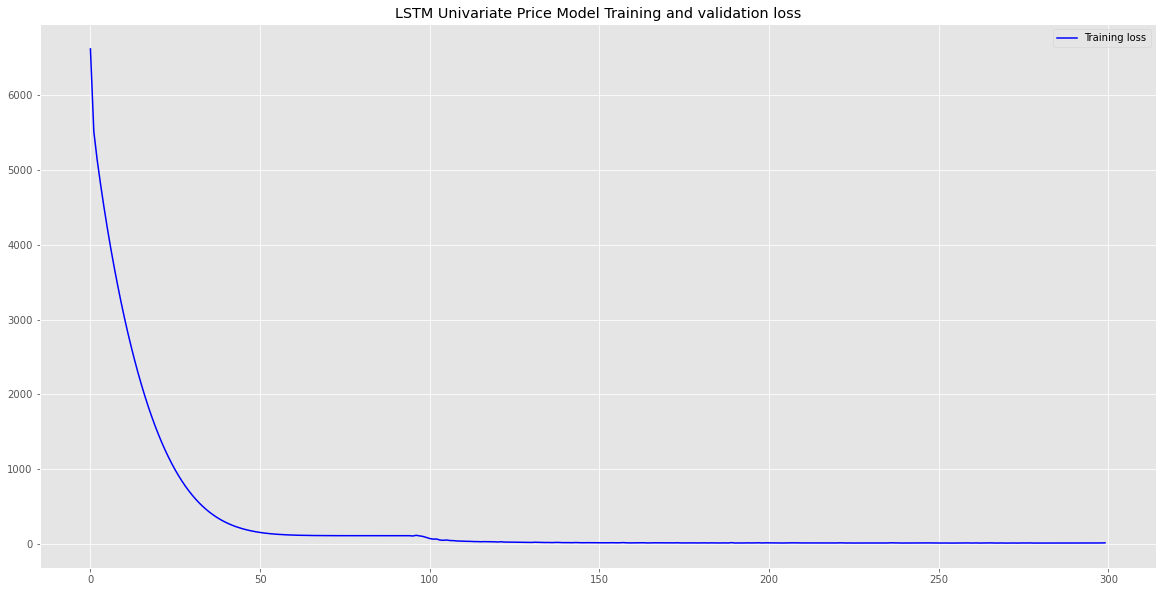

In [25]:
plot_train_history(LSTM_price_model_history, 'LSTM Univariate Price Model Training and validation loss')

In [27]:
288 * 10000 /300000

9.6

## Try again with scaled data

In [29]:
# Data Loader Parameters
BATCH_SIZE = 52
BUFFER_SIZE = 10 # 10000
TRAIN_SPLIT = 288 # ~ 70:30 300K out of 420K

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 1000
PATIENCE = 100

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 6


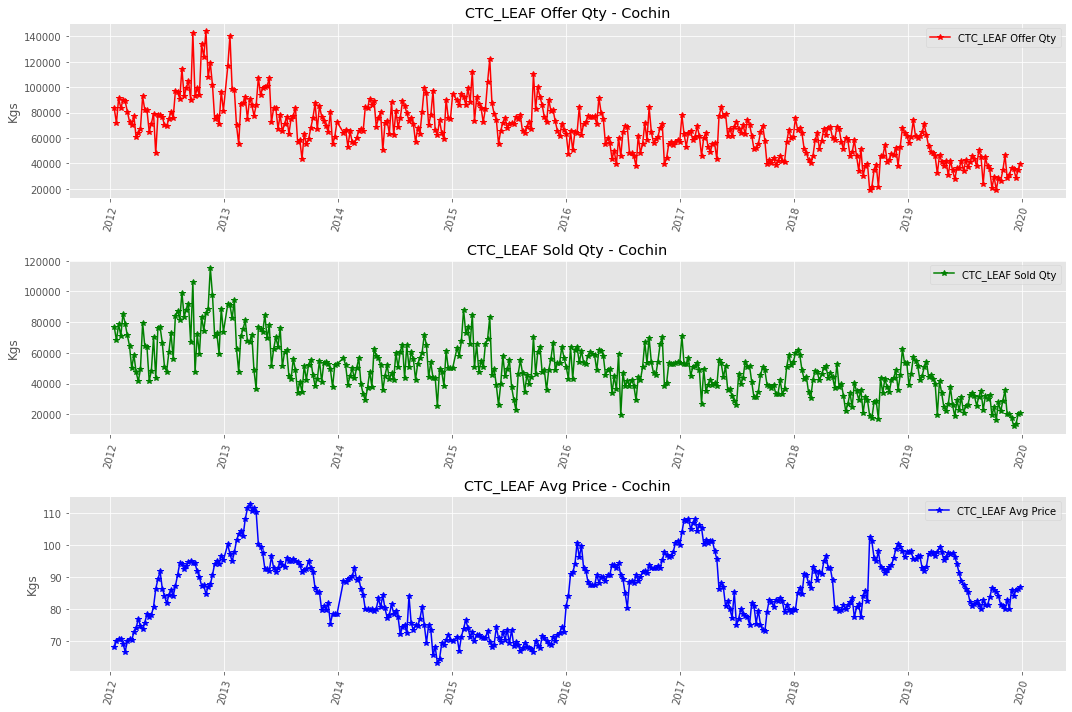

In [30]:
# Load the data again
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
# # chop out 2020 data
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# Plot it
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')

In [31]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)


In [32]:
df_CHN_CTC_leaf.info()


<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 14-Jan-12 to 28-Dec-19
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                412 non-null    int64  
 1   serial_no           412 non-null    int64  
 2   ctc_leaf_offer_qty  412 non-null    float64
 3   ctc_leaf_sold_qty   412 non-null    float64
 4   ctc_leaf_avg_price  412 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.3+ KB


In [33]:
# Prepare the data for only the average price

In [34]:
uni_data = df_CHN_CTC_leaf['ctc_leaf_avg_price']
uni_data.index = df_CHN_CTC_leaf.index

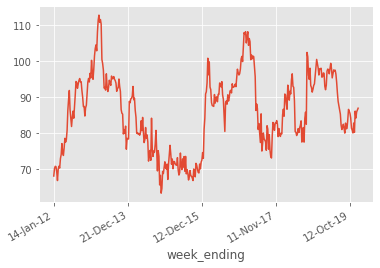

In [35]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [36]:
# Scale only the train data
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [37]:
# Create the data for the univariate model which will be given the last n_prev weeks' price observations, 
# and needs to learn to predict the temperature at the next week.
univariate_past_history = n_prev
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [38]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)


print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(412,)
[-1.44628993 -1.26760032 -1.21433707 -1.22292792 -1.34319977]

Out
(282, 6, 1)
0.6844660194174758


In [39]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (6, 1)
[[-1.44628993]
 [-1.26760032]
 [-1.21433707]
 [-1.22292792]
 [-1.34319977]
 [-1.5545346 ]]

 Target temperature to predict. Shape: ()
-1.2839229297660377


In [40]:
def create_time_steps(length):
    return list(range(-length, 0))

In [41]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

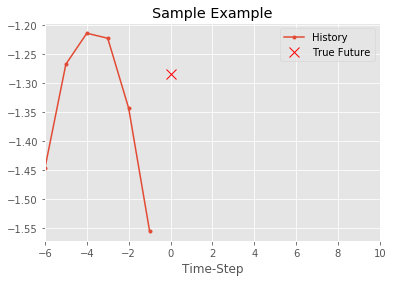

In [42]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [43]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

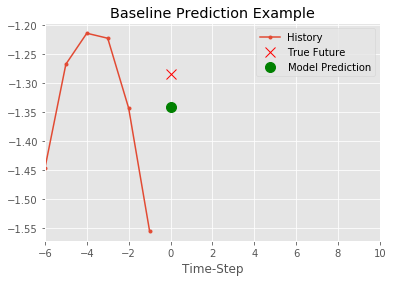

In [44]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [45]:
# Let's now use tf.data to shuffle, batch, and cache the dataset.
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [46]:
x_train_uni.shape

(282, 6, 1)

In [47]:
# Set up the model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mape')

In [48]:
# LSTM_price_model = keras.Sequential()
# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))
# LSTM_price_model.add(keras.layers.Dropout(0.1))
# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))
# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [49]:
for x, y in val_univariate.take(1):
    
    print(simple_lstm_model.predict(x).shape)

(52, 1)


In [50]:
tf.__version__

'2.3.0'

In [52]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience = 500, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=500,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/500
200/200 [==============================] - 0s 2ms/step - loss: 47.0182 - val_loss: 89.2575
Epoch 2/500
200/200 [==============================] - 0s 2ms/step - loss: 46.1493 - val_loss: 88.8784
Epoch 3/500
200/200 [==============================] - 0s 2ms/step - loss: 46.5133 - val_loss: 89.4325
Epoch 4/500
200/200 [==============================] - 0s 2ms/step - loss: 46.1485 - val_loss: 89.3961
Epoch 5/500
200/200 [==============================] - 0s 2ms/step - loss: 45.8800 - val_loss: 89.4121
Epoch 6/500
200/200 [==============================] - 0s 2ms/step - loss: 45.8021 - val_loss: 89.5547
Epoch 7/500
200/200 [==============================] - 0s 2ms/step - loss: 45.6129 - val_loss: 90.1179
Epoch 8/500
200/200 [==============================] - 0s 2ms/step - loss: 45.5512 - val_loss: 89.9024
Epoch 9/500
200/200 [==============================] - 0s 2ms/step - loss: 45.3762 - val_loss: 90.2306
Epoch 10/500
200/200 [==============================] - 0s 2ms/step - los

200/200 [==============================] - 0s 2ms/step - loss: 37.5212 - val_loss: 107.8260
Epoch 80/500
200/200 [==============================] - 0s 2ms/step - loss: 36.5872 - val_loss: 108.5166
Epoch 81/500
200/200 [==============================] - 0s 2ms/step - loss: 36.6976 - val_loss: 109.7227
Epoch 82/500
200/200 [==============================] - 0s 2ms/step - loss: 37.2231 - val_loss: 110.3316
Epoch 83/500
200/200 [==============================] - 0s 2ms/step - loss: 36.8522 - val_loss: 111.6971
Epoch 84/500
200/200 [==============================] - 0s 2ms/step - loss: 36.8854 - val_loss: 112.5789
Epoch 85/500
200/200 [==============================] - 0s 2ms/step - loss: 36.0187 - val_loss: 113.4475
Epoch 86/500
200/200 [==============================] - 0s 2ms/step - loss: 36.5433 - val_loss: 113.9306
Epoch 87/500
200/200 [==============================] - 0s 2ms/step - loss: 36.1437 - val_loss: 114.9516
Epoch 88/500
200/200 [==============================] - 0s 2ms/step 

200/200 [==============================] - 0s 2ms/step - loss: 31.9707 - val_loss: 138.2592
Epoch 157/500
200/200 [==============================] - 0s 2ms/step - loss: 31.4894 - val_loss: 137.5050
Epoch 158/500
200/200 [==============================] - 0s 2ms/step - loss: 31.4951 - val_loss: 138.0615
Epoch 159/500
200/200 [==============================] - 0s 2ms/step - loss: 32.1405 - val_loss: 138.4961
Epoch 160/500
200/200 [==============================] - 0s 2ms/step - loss: 31.0921 - val_loss: 138.9660
Epoch 161/500
200/200 [==============================] - 0s 2ms/step - loss: 31.3686 - val_loss: 139.3776
Epoch 162/500
200/200 [==============================] - 0s 2ms/step - loss: 31.2040 - val_loss: 139.1695
Epoch 163/500
200/200 [==============================] - 0s 2ms/step - loss: 31.8249 - val_loss: 139.3077
Epoch 164/500
200/200 [==============================] - 0s 2ms/step - loss: 31.5291 - val_loss: 139.3723
Epoch 165/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 2ms/step - loss: 27.9744 - val_loss: 146.8072
Epoch 234/500
200/200 [==============================] - 0s 2ms/step - loss: 27.9096 - val_loss: 146.5294
Epoch 235/500
200/200 [==============================] - 0s 2ms/step - loss: 27.5959 - val_loss: 146.7763
Epoch 236/500
200/200 [==============================] - 0s 2ms/step - loss: 28.3847 - val_loss: 146.1435
Epoch 237/500
200/200 [==============================] - 0s 2ms/step - loss: 27.8998 - val_loss: 146.6092
Epoch 238/500
200/200 [==============================] - 0s 2ms/step - loss: 27.6355 - val_loss: 147.5214
Epoch 239/500
200/200 [==============================] - 0s 2ms/step - loss: 27.7127 - val_loss: 147.2290
Epoch 240/500
200/200 [==============================] - 0s 2ms/step - loss: 27.6804 - val_loss: 147.2148
Epoch 241/500
200/200 [==============================] - 0s 2ms/step - loss: 27.6447 - val_loss: 147.0372
Epoch 242/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 2ms/step - loss: 25.6602 - val_loss: 148.6067
Epoch 311/500
200/200 [==============================] - 0s 2ms/step - loss: 26.6714 - val_loss: 149.5524
Epoch 312/500
200/200 [==============================] - 0s 2ms/step - loss: 25.8032 - val_loss: 149.0329
Epoch 313/500
200/200 [==============================] - 0s 2ms/step - loss: 26.4566 - val_loss: 149.1875
Epoch 314/500
200/200 [==============================] - 0s 2ms/step - loss: 26.4262 - val_loss: 149.0417
Epoch 315/500
200/200 [==============================] - 0s 2ms/step - loss: 26.2616 - val_loss: 149.2052
Epoch 316/500
200/200 [==============================] - 0s 2ms/step - loss: 26.0632 - val_loss: 149.5719
Epoch 317/500
200/200 [==============================] - 0s 2ms/step - loss: 25.5888 - val_loss: 148.8067
Epoch 318/500
200/200 [==============================] - 0s 2ms/step - loss: 26.3761 - val_loss: 150.0092
Epoch 319/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 2ms/step - loss: 24.2905 - val_loss: 151.2440
Epoch 388/500
200/200 [==============================] - 0s 2ms/step - loss: 24.6687 - val_loss: 150.6290
Epoch 389/500
200/200 [==============================] - 0s 2ms/step - loss: 24.3294 - val_loss: 151.0559
Epoch 390/500
200/200 [==============================] - 0s 2ms/step - loss: 24.0283 - val_loss: 151.3095
Epoch 391/500
200/200 [==============================] - 0s 2ms/step - loss: 23.8838 - val_loss: 151.2418
Epoch 392/500
200/200 [==============================] - 0s 2ms/step - loss: 24.6633 - val_loss: 151.5034
Epoch 393/500
200/200 [==============================] - 0s 2ms/step - loss: 23.9976 - val_loss: 151.1505
Epoch 394/500
200/200 [==============================] - 0s 2ms/step - loss: 23.9240 - val_loss: 150.8593
Epoch 395/500
200/200 [==============================] - 0s 2ms/step - loss: 23.9776 - val_loss: 151.4758
Epoch 396/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 2ms/step - loss: 22.7294 - val_loss: 147.5479
Epoch 465/500
200/200 [==============================] - 0s 2ms/step - loss: 22.8083 - val_loss: 146.5802
Epoch 466/500
200/200 [==============================] - 0s 2ms/step - loss: 23.2193 - val_loss: 147.4265
Epoch 467/500
200/200 [==============================] - 0s 2ms/step - loss: 23.0327 - val_loss: 147.1382
Epoch 468/500
200/200 [==============================] - 0s 2ms/step - loss: 22.3629 - val_loss: 147.5575
Epoch 469/500
200/200 [==============================] - 0s 2ms/step - loss: 22.6226 - val_loss: 147.0576
Epoch 470/500
200/200 [==============================] - 0s 2ms/step - loss: 23.4144 - val_loss: 147.4543
Epoch 471/500
200/200 [==============================] - 0s 2ms/step - loss: 23.0825 - val_loss: 147.0986
Epoch 472/500
200/200 [==============================] - 0s 2ms/step - loss: 22.3536 - val_loss: 146.5428
Epoch 473/500
200/200 [==============================] - 0s 

### Predict

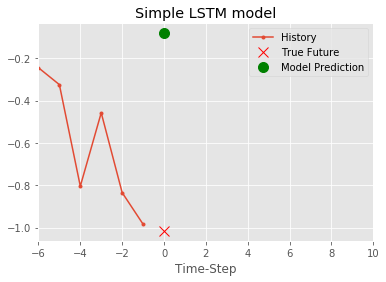

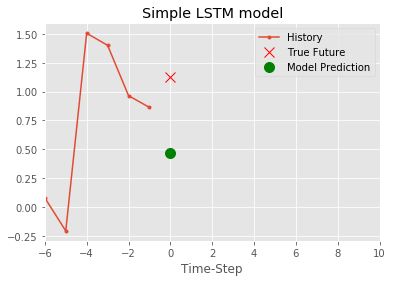

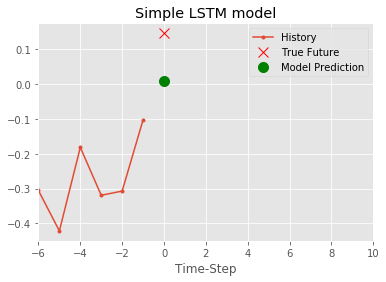

In [53]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

#### Poor results for univariate!

## Multivariate

In [82]:
# Data Loader Parameters
BATCH_SIZE = 52
BUFFER_SIZE = 10 # 10000
TRAIN_SPLIT = 288 # ~ 70:30 300K out of 420K

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 1000
PATIENCE = 1000

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 6


First for 3 features from the same tea category (CTC Leaf): ctc_leaf_avg_price, ctc_leaf_offer_qty & ctc_leaf_sold_qty.

In [69]:
features_considered = ['ctc_leaf_sold_qty', 'ctc_leaf_avg_price', 'ctc_leaf_offer_qty']

In [70]:
features = df_CHN_CTC_leaf[features_considered]
features.index = df_CHN_CTC_leaf.index
features.head()

,ctc_leaf_sold_qty,ctc_leaf_avg_price,ctc_leaf_offer_qty
week_ending,,,
14-Jan-12,77015.0,68.03,83325.0
21-Jan-12,68187.0,70.11,71897.0
28-Jan-12,78695.0,70.73,91279.0
4-Feb-12,71188.0,70.63,83746.0
11-Feb-12,85480.0,69.23,89650.0


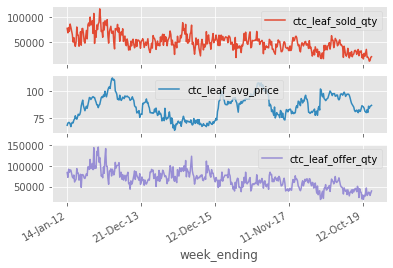

In [71]:
features.plot(subplots=True);

Standardize the dataset using the mean and standard deviation of the training data.

In [72]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [73]:
pd.DataFrame(dataset, columns = features.columns, index= features.index).head()

,ctc_leaf_sold_qty,ctc_leaf_avg_price,ctc_leaf_offer_qty
week_ending,,,
14-Jan-12,1.357758,-1.446290,0.468435
21-Jan-12,0.796453,-1.267600,-0.183496
28-Jan-12,1.464576,-1.214337,0.922186
4-Feb-12,0.987264,-1.222928,0.492452
11-Feb-12,1.895982,-1.343200,0.829257


#### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the windowing task as below, however, here it samples the past observation based on the step size given.

In [87]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

The model is shown data from the last n_prev weeks.
For the single step prediction model, the label for a datapoint is the price 1 weeks into the future. 

In [95]:
past_history = n_prev # 6 weeks .... 720
future_target = 1 # after 3 weeks   .... 72
STEP = 1 # ... 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.

In [96]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(282, 6, 3)
Single window of past history : (6, 3)
(6, 3)


In [97]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [98]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

Let's check out a sample prediction.

In [99]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(52, 1)


In [83]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 1000
Epoch 1/1000
200/200 [==============================] - 1s 3ms/step - loss: 56.5863 - val_loss: 109.3885
Epoch 2/1000
200/200 [==============================] - 1s 3ms/step - loss: 54.3920 - val_loss: 111.2787
Epoch 3/1000
200/200 [==============================] - 1s 3ms/step - loss: 53.4930 - val_loss: 114.1581
Epoch 4/1000
200/200 [==============================] - 1s 3ms/step - loss: 52.1772 - val_loss: 119.0772
Epoch 5/1000
200/200 [==============================] - 1s 3ms/step - loss: 50.9378 - val_loss: 125.8182
Epoch 6/1000
200/200 [==============================] - 1s 3ms/step - loss: 50.0627 - val_loss: 138.6332
Epoch 7/1000
200/200 [==============================] - 1s 3ms/step - loss: 48.5482 - val_loss: 154.1250
Epoch 8/1000
200/200 [==============================] - 1s 3ms/step - loss: 46.9821 - val_loss: 175.5522
Epoch 9/1000
200/200 [==============================] - 1s 3ms/step - loss: 46.1310 - val_loss: 203.7861
Epoch 10/1000
20

200/200 [==============================] - 1s 3ms/step - loss: 12.9749 - val_loss: 247.9431
Epoch 79/1000
200/200 [==============================] - 1s 3ms/step - loss: 12.8101 - val_loss: 242.4095
Epoch 80/1000
200/200 [==============================] - 1s 3ms/step - loss: 12.5396 - val_loss: 250.4922
Epoch 81/1000
200/200 [==============================] - 1s 3ms/step - loss: 12.3486 - val_loss: 244.2685
Epoch 82/1000
200/200 [==============================] - 1s 3ms/step - loss: 12.2615 - val_loss: 244.0775
Epoch 83/1000
200/200 [==============================] - 1s 3ms/step - loss: 11.9637 - val_loss: 239.3517
Epoch 84/1000
200/200 [==============================] - 1s 3ms/step - loss: 11.7604 - val_loss: 245.7295
Epoch 85/1000
200/200 [==============================] - 1s 3ms/step - loss: 11.8484 - val_loss: 243.2660
Epoch 86/1000
200/200 [==============================] - 1s 3ms/step - loss: 11.7049 - val_loss: 240.5337
Epoch 87/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 7.0169 - val_loss: 244.4261
Epoch 156/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.9368 - val_loss: 240.6425
Epoch 157/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.9136 - val_loss: 237.6934
Epoch 158/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.7457 - val_loss: 243.2115
Epoch 159/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.7770 - val_loss: 239.8387
Epoch 160/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.5759 - val_loss: 248.4511
Epoch 161/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.6477 - val_loss: 245.6619
Epoch 162/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.7290 - val_loss: 243.9392
Epoch 163/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.7948 - val_loss: 247.6021
Epoch 164/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 6.3549 - val_loss: 246.4570
Epoch 233/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.2874 - val_loss: 248.1952
Epoch 234/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.3337 - val_loss: 249.4906
Epoch 235/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.0958 - val_loss: 244.9226
Epoch 236/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.0330 - val_loss: 245.0421
Epoch 237/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.2781 - val_loss: 249.8222
Epoch 238/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.1565 - val_loss: 244.5045
Epoch 239/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.0556 - val_loss: 245.4495
Epoch 240/1000
200/200 [==============================] - 1s 3ms/step - loss: 6.0860 - val_loss: 244.4462
Epoch 241/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 5.6165 - val_loss: 227.7699
Epoch 310/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.5732 - val_loss: 232.2093
Epoch 311/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.6454 - val_loss: 226.4650
Epoch 312/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.7337 - val_loss: 227.3806
Epoch 313/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.5573 - val_loss: 226.9642
Epoch 314/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.7189 - val_loss: 226.2063
Epoch 315/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.5771 - val_loss: 225.0350
Epoch 316/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.4895 - val_loss: 224.7526
Epoch 317/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.5365 - val_loss: 226.0322
Epoch 318/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 5.3554 - val_loss: 240.9640
Epoch 387/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.5085 - val_loss: 244.7405
Epoch 388/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.3796 - val_loss: 240.0176
Epoch 389/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.4150 - val_loss: 242.8695
Epoch 390/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.2967 - val_loss: 241.0446
Epoch 391/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.1739 - val_loss: 241.3785
Epoch 392/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.1754 - val_loss: 242.6694
Epoch 393/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.3737 - val_loss: 241.9398
Epoch 394/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.3531 - val_loss: 246.1092
Epoch 395/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 4.9036 - val_loss: 247.6622
Epoch 464/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.0724 - val_loss: 249.8342
Epoch 465/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.9810 - val_loss: 251.2668
Epoch 466/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.0034 - val_loss: 253.5820
Epoch 467/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.9579 - val_loss: 252.0926
Epoch 468/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.1070 - val_loss: 247.9445
Epoch 469/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.0968 - val_loss: 249.7180
Epoch 470/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.9245 - val_loss: 249.9282
Epoch 471/1000
200/200 [==============================] - 1s 3ms/step - loss: 5.2520 - val_loss: 247.5338
Epoch 472/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 4.7149 - val_loss: 245.3372
Epoch 541/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.6787 - val_loss: 248.0312
Epoch 542/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.7264 - val_loss: 250.1468
Epoch 543/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.8484 - val_loss: 247.8537
Epoch 544/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.8352 - val_loss: 248.8677
Epoch 545/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.6724 - val_loss: 250.7327
Epoch 546/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.8283 - val_loss: 250.6844
Epoch 547/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.7966 - val_loss: 251.4363
Epoch 548/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.7200 - val_loss: 248.7784
Epoch 549/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 3.9844 - val_loss: 248.4007
Epoch 618/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.9806 - val_loss: 247.5321
Epoch 619/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.8626 - val_loss: 249.2276
Epoch 620/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.9053 - val_loss: 246.1057
Epoch 621/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.0362 - val_loss: 246.3250
Epoch 622/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.9981 - val_loss: 246.0642
Epoch 623/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.8461 - val_loss: 249.5202
Epoch 624/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.9470 - val_loss: 251.6061
Epoch 625/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.8714 - val_loss: 248.5816
Epoch 626/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 3.0732 - val_loss: 233.7109
Epoch 695/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.9855 - val_loss: 233.8851
Epoch 696/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.1029 - val_loss: 236.5985
Epoch 697/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.1060 - val_loss: 232.3733
Epoch 698/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.9651 - val_loss: 232.9411
Epoch 699/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.9258 - val_loss: 233.1440
Epoch 700/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.9509 - val_loss: 234.7651
Epoch 701/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.9406 - val_loss: 237.4833
Epoch 702/1000
200/200 [==============================] - 1s 3ms/step - loss: 3.0257 - val_loss: 236.9801
Epoch 703/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 2.6458 - val_loss: 231.3095
Epoch 772/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.6718 - val_loss: 231.6817
Epoch 773/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.5939 - val_loss: 231.4491
Epoch 774/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.6826 - val_loss: 228.7354
Epoch 775/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.6719 - val_loss: 230.3007
Epoch 776/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.6750 - val_loss: 229.5253
Epoch 777/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.6861 - val_loss: 231.6422
Epoch 778/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.7201 - val_loss: 231.6761
Epoch 779/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.6133 - val_loss: 228.4653
Epoch 780/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 2.4812 - val_loss: 228.1241
Epoch 849/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.5321 - val_loss: 228.8149
Epoch 850/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.4949 - val_loss: 227.5335
Epoch 851/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.4713 - val_loss: 228.8074
Epoch 852/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.5310 - val_loss: 229.7726
Epoch 853/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.5399 - val_loss: 229.2202
Epoch 854/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.5078 - val_loss: 229.5562
Epoch 855/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.5600 - val_loss: 227.2406
Epoch 856/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.4773 - val_loss: 224.7524
Epoch 857/1000
200/200 [==============================] - 1s 

200/200 [==============================] - 1s 3ms/step - loss: 2.3359 - val_loss: 228.8873
Epoch 926/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3412 - val_loss: 229.0177
Epoch 927/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3863 - val_loss: 229.1441
Epoch 928/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3860 - val_loss: 230.4618
Epoch 929/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3528 - val_loss: 231.1330
Epoch 930/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.4303 - val_loss: 232.1852
Epoch 931/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3286 - val_loss: 232.6604
Epoch 932/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3221 - val_loss: 229.0164
Epoch 933/1000
200/200 [==============================] - 1s 3ms/step - loss: 2.3898 - val_loss: 232.2729
Epoch 934/1000
200/200 [==============================] - 1s 

In [93]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

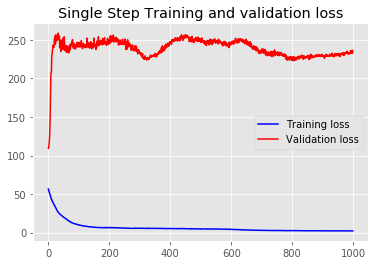

In [94]:
plot_train_history(single_step_history,
                   'Single Step Training and Validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past n_prev weeks, and is to predict the price 3 weeks into the future. The plot only displays the past prices. Since the prediction is made 3 weeks into the future, there is a gap between the history and prediction).

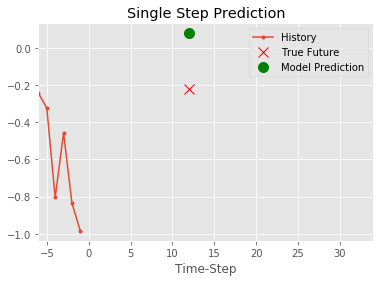

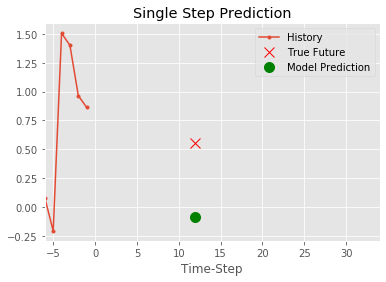

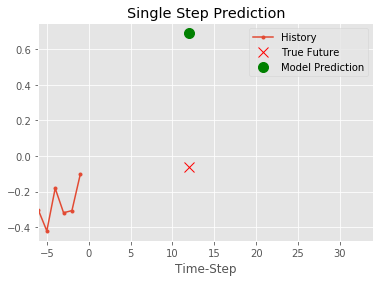

In [86]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.